In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

HTML_IMG_SIZE = {'x':285.0, 'y':435.0}
GROUP1_TRIANGLES = json.load(open('../images/image_params_group1.json','r'))
GROUP2_TRIANGLES = json.load(open('../images/image_params_group2.json','r'))
PRACTICE_TRIANGLE = json.load(open('../images/image_params_practice.json','r'))
TURK_COLUMNS = ['WorkerId', 'Answer.group', 'Answer.pracX', 'Answer.pracY', 'Answer.pracRT', 
             'Answer.trialIndex', 'Answer.trialImg','Answer.taskX', 'Answer.taskY', 'Answer.taskRT']
RENAME_COLUMNS = {'Answer.group': 'group', 'Answer.pracX': 'pracX','Answer.pracY': 'pracY',
                 'Answer.pracRT': 'pracRT', 'Answer.trialIndex': 'trialIndex', 'Answer.trialImg': 'trialImg',
                 'Answer.taskX': 'taskX', 'Answer.taskY': 'taskY', 'Answer.taskRT': 'taskRT'}

### Extract columns, organize data, and append triangle params to data

In [2]:
def extract_cols(data):
    data = data[TURK_COLUMNS]
    data = data.rename(columns=RENAME_COLUMNS)
    return data

def split_values(string, token=','):
    values = string.split(token)[1:] # first value is a leading placeholder
    return np.array([np.float(x) for x in values])

def organize_data_subject(data, subject):
    
    trialIndex = split_values(data['trialIndex'].values[0]).astype(np.int)
    trialImg = split_values(data['trialImg'].values[0]).astype(np.int)
    taskX = split_values(data['taskX'].values[0])
    taskY = split_values(data['taskY'].values[0])
    taskRT = split_values(data['taskRT'].values[0])
    colnames = ['subject', 'group', 'trial', 'img', 'estX', 'estY', 'rt']
    
    # practice trial
    subject_data = [[subject, data['group'].values[0], 'practice', 'practice', 
                     data['pracX'].values[0], data['pracY'].values[0], data['pracRT'].values[0]]]
    # task trials
    for i in trialIndex:
        subject_data.append([subject, data['group'].values[0], trialIndex[i], trialImg[i],
                              taskX[i], taskY[i], taskRT[i]])
    
    subject_data = pd.DataFrame(subject_data, columns=colnames)
    return subject_data
        
def organize_data(data):
    subjects = np.unique(data['WorkerId'])
    new_data = [organize_data_subject(data[data['WorkerId']==s], i) for i,s in enumerate(subjects)]
    new_data = pd.concat(new_data, ignore_index=True)
    return new_data

def add_scaledXY(data):
    # append to data in place
    # convert click coordinates into triangle coords ([0,1]), 
    # where 1=285px (max baseLen=1=285px, max topY=1.123018=320px)
    # note that the click y-coordinate in js is relative to the top of the image container
    scaledX = data['estX'].values / HTML_IMG_SIZE['x']
    scaledY = (HTML_IMG_SIZE['y'] - data['estY'].values) / HTML_IMG_SIZE['x']
    data['scaledX'] = scaledX
    data['scaledY'] = scaledY

def add_triangle_params(data):
    # add triangle params for each (group, image)
    column_names = ['baseAngle', 'baseLen', 'sideLen', 'height', 
                    'leftX', 'leftY', 'rightX', 'rightY', 'topX', 'topY']
    triangle_params = []
    
    for i in range(len(data)):
        
        row = data.iloc[i]
        group = row['group']
        img = row['img']
        config = None
        if (img == 'practice'):
            config = PRACTICE_TRIANGLE
        elif (group==1):
            config = GROUP1_TRIANGLES[str(img)] # image number is a str dict key
        elif (group==2):
            config = GROUP2_TRIANGLES[str(img)]
        else:
            print("This shouldn't happen...")
        
        triangle_params.append([config['base_angle'], config['base_len'], 
                                config['side_len'], config['height'],
                                config['L_coord'][0], config['L_coord'][1],
                                config['R_coord'][0], config['R_coord'][1],
                                config['T_coord'][0], config['T_coord'][1]])
        
    triangle_params = pd.DataFrame(triangle_params, columns=column_names, dtype=np.int64)
    return data.join(triangle_params)

def preprocess_data(fname):
    data = pd.read_csv(fname)# read data
    new_data = organize_data(extract_cols(data.copy())) # extract columns
    add_scaledXY(new_data) # add scaled (x,y) click, inplace
    new_data = add_triangle_params(new_data) # add true triangle params
    return new_data

### Final Data

In [3]:
fnames = ['../data/final_g1.csv', '../data/final_g2.csv']
groupN = 20
data = [preprocess_data(f) for f in fnames]
data[1].subject = data[1].subject + groupN # subjects are 0-N in each group, so we'll increase subject number in group2 by N
data = pd.concat(data, ignore_index=True)
data.to_csv('../data/final_postprocess_corrected.csv')

In [4]:
len(data)

6040

### Pilot-B data

In [5]:
fnames = ['../data/pilotb_g1.csv', '../data/pilotb_g2.csv']
groupN = 2
data = [preprocess_data(f) for f in fnames]
data[1].subject = data[1].subject + groupN # subjects are 0-N in each group, so we'll increase subject number in group2 by N
data = pd.concat(data, ignore_index=True)
data.to_csv('../data/pilotb_postprocess_indexcorrected.csv')

### Sanity Check
<p> The test batch 1 results are from a turk sandbox test where I intentially clicked the left vertex of the triangle (30 trials).

In [3]:
fname = '../data/test_batch1_results.csv'
data = preprocess_data(fname)

In [4]:
data.head()

,subject,group,trial,img,estX,estY,rt,scaledX,scaledY,baseAngle,baseLen,sideLen,height,leftX,leftY,rightX,rightY,topX,topY
0,0,2,practice,practice,50.0,435.0,2317.0,0.175439,0.000000,56,0.66,0.590136,0.489245,0.170,0,0.830,0,0.5,0.489245
1,0,2,0,2,126.0,435.0,1385.0,0.442105,0.000000,66,0.10,0.122930,0.112302,0.450,0,0.550,0,0.5,0.112302
2,0,2,1,13,1.0,434.0,1398.0,0.003509,0.002299,51,1.00,0.794508,0.617449,0.000,0,1.000,0,0.5,0.617449
3,0,2,2,5,107.0,436.0,1316.0,0.375439,-0.002299,66,0.25,0.307324,0.280755,0.375,0,0.625,0,0.5,0.280755
4,0,2,3,14,1.0,435.0,1150.0,0.003509,0.000000,66,1.00,1.229297,1.123018,0.000,0,1.000,0,0.5,1.123018


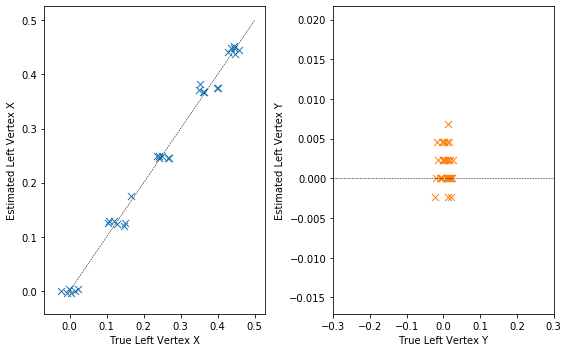

In [5]:
fig, axes = plt.subplots(1,2,figsize=[8,5])

# add some jitter to x axis
x = data['leftX'].copy()
x += (np.random.rand(len(x))-0.5)/20 # add some jitter
y = data['scaledX']
axes[0].scatter(x, y, c='C0', lw=1, marker='x', s=50)
axes[0].plot([0,0.5],[0,0.5], '--k', lw=0.5)

x = data['leftY'].copy()
x += (np.random.rand(len(x))-0.5)/20 # add some jitter
y = data['scaledY']
axes[1].scatter(x, y, c='C1', lw=1, marker='x', s=50)
axes[1].axhline(0, ls='--', c='k', lw=0.5)

axes[1].set_xlim([-0.3, 0.3])
axes[0].set_xlabel('True Left Vertex X')
axes[0].set_ylabel('Estimated Left Vertex X')
axes[1].set_xlabel('True Left Vertex Y')
axes[1].set_ylabel('Estimated Left Vertex Y')

fig.tight_layout()
# fig.savefig('plot/sanity_check.pdf')

### Mock data
<p> The test batch 2 results are from a turk sandbox test where I completed the task (150 trials).

In [4]:
fname = '../data/test_batch2_results.csv'
data = preprocess_data(fname)
# data.to_csv('../data/batch2_postprocess.csv')
data = data[data['trial']!='practice']

In [26]:
data.head()

,subject,group,trial,img,estX,estY,rt,scaledX,scaledY,baseAngle,baseLen,sideLen,height,leftX,leftY,rightX,rightY,topX,topY
1,0,1,0,10,171.166626,348.666666,1220.0,0.600585,0.198467,45,0.75,0.530330,0.375000,0.125,0,0.875,0,0.5,0.375000
1,1,1,0,13,138.000000,307.000000,4249.0,0.484211,0.294253,45,0.75,0.530330,0.375000,0.125,0,0.875,0,0.5,0.375000
2,0,1,1,7,254.166626,354.666666,357.0,0.891813,0.184674,45,0.50,0.353553,0.250000,0.250,0,0.750,0,0.5,0.250000
2,1,1,1,13,138.000000,289.000000,1809.0,0.484211,0.335632,45,0.50,0.353553,0.250000,0.250,0,0.750,0,0.5,0.250000
3,0,1,2,3,333.166626,365.666666,384.0,1.169006,0.159387,30,0.25,0.144338,0.072169,0.375,0,0.625,0,0.5,0.072169


In [27]:
len(data)

300

IndexError: list index out of range

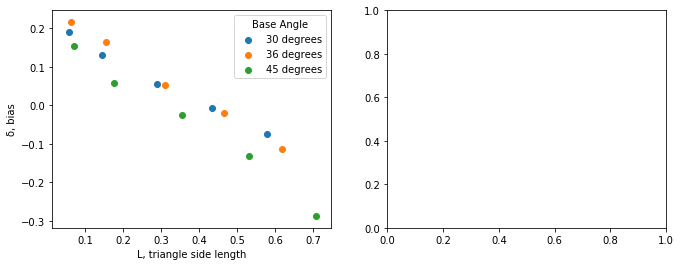

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[11,4])

# Plot 1:
#     The mean deviation (δ) from the true y-coordinate location is
#     biased downwards toward the triangle’s base and 
#     scale linearly with triangle side length
for i, a in enumerate(np.unique(data['baseAngle'])):
    colors = ['C0', 'C1', 'C2']
    
    sliced_data = data[data['baseAngle']==a]
    deltas = sliced_data['scaledY'] - sliced_data['topY']
    side_lens = sliced_data['sideLen']
    unique_side_lens = np.unique(side_lens)
    mean_deltas = [np.nanmean(deltas[side_lens==l]) for l in unique_side_lens]
    # yerrs = [np.std(deltas[side_lens==l]) for l in unique_side_lens] # across trial
    
    axes[0].scatter(unique_side_lens, mean_deltas, 
                    color=colors[i], label='%d degrees'%a)
    # axes[0].errorbar(unique_side_lens, mean_deltas, yerr=yerrs, 
    #                  color=colors[i], capsize=3, fmt='none')
    
    axes[0].set_xlabel('L, triangle side length')
    axes[0].set_ylabel('δ, bias')
    axes[0].legend(title='Base Angle')

# Plot 2:
#     The standard deviation of participants’ distribution of responses (σ)
#     scales sub-linearly with the side length
for i, b in enumerate(np.unique(data['baseLen'])):
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    
    sliced_data = data[data['baseLen']==b]
    scaled_ys = sliced_data['scaledY']
    side_lens = sliced_data['sideLen']
    unique_side_lens = np.unique(side_lens)
    std_scaledYs = [np.std(scaled_ys[side_lens==l]) for l in unique_side_lens]
    
    axes[1].scatter(unique_side_lens, std_scaledYs, 
                    color=colors[i], label='%.2f'%b)
    
    axes[1].set_xlabel('L, triangle side length')
    axes[1].set_ylabel('σ, std')
    axes[1].legend(title='Base Length')
    
    
fig.tight_layout()
# fig.savefig('plot/sanity_check2.pdf')